# The German Traffic Sign Recognition Benchmark

In [1]:
# importing the required packages
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pickle
import csv
import cv2
import imutils
from PIL import Image
from skimage import exposure, feature, transform
%matplotlib inline

# classification required packages
from sklearn import datasets
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.externals import joblib

In [17]:
# helper functions 

# function for reading the images
# arguments: path to the traffic sign data, for example '../../GTSRB/train/Final_Training/Images/'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example '../../GTSRB/train/Final_Training/Images/'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        gtReader.next() # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels


def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray


def showimg_n_hog(grayimg,hogImage):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(grayimg)
    ax1.set_title('Input image')
    ax1.set_adjustable('box-forced')

    ax2.axis('off')
    ax2.imshow(hogImage, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box-forced')
    plt.show()

In [18]:
if os.path.isfile("Image_n_Labels/trainImages.npy") &  os.path.isfile("Image_n_Labels/trainLabels.npy") :
    X = np.load("Image_n_Labels/trainImages.npy")
    y = np.load("Image_n_Labels/trainLabels.npy")
    print("Training images and labels are loaded in variables ==> X,y")
    print("Number of training Images {} \nNumber of Labels {}".format(len(X), len(y)))
else:    
    # training images and labels
    trainImages, trainLabels = readTrafficSigns('../../GTSRB/train/Final_Training/Images/')
    np.save("Image_n_Labels/trainImages.npy",trainImages)
    np.save("Image_n_Labels/trainLabels.npy",trainLabels)
    print("training images and labels are read from the dataset directory")
    print("training images saved to Image_n_Labels/trainingImages.npy for further use")
    print("training labels saved to Image_n_Labels/trainingLabels.npy for further use")

Training images and labels are loaded in variables ==> X,y
Number of training Images 39209 
Number of Labels 39209


In [19]:
y.astype("float")

array([  0.,   0.,   0., ...,  42.,  42.,  42.])

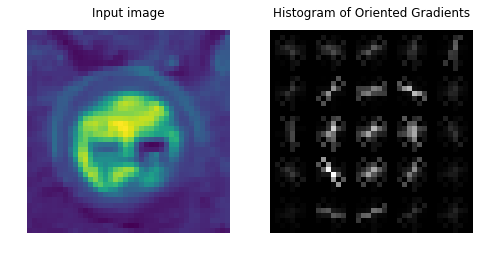

576


In [20]:
# simple test on single image for HoG features
n = np.random.randint(0,len(X))
i1 = X[n]
grayim = rgb2gray(i1)
gI1 = transform.resize(grayim,(40,40))
# gI2 = cv2.resize(grayim, (40, 40), interpolation = cv2.INTER_CUBIC)

(H, hogImage) = feature.hog(gI1, orientations=9, pixels_per_cell=(8,8),
	cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")

showimg_n_hog(gI1, hogImage)
print(len(H))

In [8]:
if os.path.isfile("HoGFeatures/HoGfeatures.npy") & os.path.isfile("HoGFeatures/HoGvisualize.npy") :
    hogfeat = np.load("HoGFeatures/HoGfeatures.npy")
    hogviz = np.load("HoGFeatures/HoGvisualize.npy")
    
    print("HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat")
    print("HoG visualizations are loaded from HoGvisualize.npy to variable ==> hogviz")
else:
    print("HoGfeatures.npy does not found")
    Hviz = []
    Hfeat = []
    for i in range(0,len(x)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(x)))
        I = x[i]
        grayim = rgb2gray(I)
        grayim = transform.resize(grayim,(40,40))

        (H_4x4, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(4, 4),
            cells_per_block=(2, 2), transform_sqrt=True, visualise=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
#         hogImage = hogImage.astype("uint8")
        Hviz.append(hogImage)
        Hfeat.append(H_4x4)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("HoGFeatures/HoGfeatures.npy", Hfeat)
    np.save("HoGFeatures/HoGvisualize.npy", Hviz)
    print("HoGfeatures.npy are saved")  
    print("HoGvisualize.npy are saved")

HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat
HoG visualizations are loaded from HoGvisualize.npy to variable ==> hogviz


In [9]:
X = np.array(hogfeat).astype("float")
y = y.astype("float")
print(X.shape,y.shape)
print(np.unique(y))

((39209, 2916), (39209,))
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.]


In [13]:
# y1 = np.where(y==1) 
# y2 = np.where(y==2) 
# print(y1)
# print(y2)

for i in range(0,len(np.unique(y))):
    yi = np.where(y==i)
#     print("label: {}  \n indices: {} ".format(i,yi))

## Classifier 1
## SVM cross validation score

In [73]:
clf = LinearSVC()
clf.fit(X,y)
scores = cross_val_score(clf,X,y)

In [74]:
scores.mean() 

0.92101315426064667

## Classifier 2
## One vs. One Classifier

In [92]:
ovo = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X,y)

In [81]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,train_size=0.8)

In [82]:
print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)

((31367, 2916), (31367,))
((7842, 2916), (7842,))


## Classifier 1
## Linear SVC

In [83]:
clf = LinearSVC()
clf.fit(Xtrain,ytrain)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [84]:
clf.score(Xtest,ytest)

0.97857689364957923

In [90]:
clf.predict(X[38729,:])

/home/shravankumar/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 41.])

In [97]:
# MLP
mlp = MLPClassifier(hidden_layer_sizes=(200,))
mlp.fit(X,y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [98]:
mlp.score(X,y)

0.99984697390905153

In [101]:
mlp.predict(X[38729])

/home/shravankumar/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 41.])